<a href="https://colab.research.google.com/github/apipz123456/Aplikasi-Pengolahan-Citra-Berbasis-Dekstop/blob/main/GroUp_stunting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dataset dari github

In [2]:
!git clone https://github.com/DenisKai7/GroUp.git

Cloning into 'GroUp'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 184 (delta 6), reused 2 (delta 0), pack-reused 168 (from 1)
Receiving objects: 100% (184/184), 1.14 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [3]:
%cd GroUp
!git checkout dataset

/content/GroUp
Branch 'dataset' set up to track remote branch 'dataset' from 'origin'.
Switched to a new branch 'dataset'


In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00


Import Library yang dibutuhkan

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

**Preprocessing**

load dataset

In [6]:
#Load Dataset
data_path = '/content/GroUp/Stunting_Dataset.csv'
nutrition_data_path = '/content/GroUp/nutrition.csv'
data = pd.read_csv(data_path)
nutrition_data = pd.read_csv(nutrition_data_path)

#Preprocessing Data
class DataPreprocessor:
    def __init__(self, data):
        self.data = data
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def preprocess(self):
        # Handle missing values
        self._handle_missing_values()
        # Feature engineering
        self._feature_engineering()
        return self._prepare_model_data()

    def _handle_missing_values(self):
        numeric_columns = self.data.select_dtypes(include=[np.number]).columns
        self.data[numeric_columns] = self.data[numeric_columns].fillna(
            self.data[numeric_columns].median()
        )

    def _feature_engineering(self):
        self.data['BMI'] = self.data['Body Weight'] / ((self.data['Body Length'] / 100) ** 2)
        self.data['Gender_Encoded'] = self.label_encoder.fit_transform(self.data['Gender'])

    def _prepare_model_data(self):
        features = ['Age', 'Birth Weight', 'Birth Length', 'Body Weight',
                    'Body Length', 'BMI', 'Gender_Encoded']
        X = self.data[features]
        y = self.label_encoder.fit_transform(self.data['Stunting'])

        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, y

preprocessor = DataPreprocessor(data)
X, y = preprocessor.preprocess()

In [7]:
class ModelTrainer:
    def __init__(self):
        self.models = {}

    def train_random_forest(self, X, y):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
            }

            rf = RandomForestClassifier(**params)
            rf.fit(X, y)

            y_pred = rf.predict(X)
            return accuracy_score(y, y_pred)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)

        best_rf = RandomForestClassifier(**study.best_params)
        best_rf.fit(X, y)
        return best_rf, study.best_params

trainer = ModelTrainer()
rf_model, rf_params = trainer.train_random_forest(X, y)

[I 2024-11-22 15:28:48,104] A new study created in memory with name: no-name-86ba917f-3232-475c-a6f3-e6892552da48
[I 2024-11-22 15:28:50,286] Trial 0 finished with value: 0.8782 and parameters: {'n_estimators': 245, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 0 with value: 0.8782.
[I 2024-11-22 15:28:53,088] Trial 1 finished with value: 0.8609 and parameters: {'n_estimators': 265, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: 0.8782.
[I 2024-11-22 15:28:54,518] Trial 2 finished with value: 0.8594 and parameters: {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 0 with value: 0.8782.
[I 2024-11-22 15:28:59,269] Trial 3 finished with value: 0.8862 and parameters: {'n_estimators': 277, 'max_depth': 10, 'min_samples_split': 9}. Best is trial 3 with value: 0.8862.
[I 2024-11-22 15:29:00,648] Trial 4 finished with value: 0.8525 and parameters: {'n_estimators': 108, 'max_depth': 3, 'min_samples_split': 3}. Best is trial 3 with value

In [8]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae', 'mse'])
    return model

X_lstm = np.expand_dims(X, axis=2)
y_lstm = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2)

lstm_model = create_lstm_model((X_train.shape[1], 1))
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

lstm_model.summary()

print("Training Loss:", lstm_history.history['loss'][-1])
print("Validation Loss:", lstm_history.history['val_loss'][-1])
print("Training Mean Absolute Error:", lstm_history.history['mae'][-1])
print("Validation Mean Absolute Error:", lstm_history.history['val_mae'][-1])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2828 - mae: 0.4318 - mse: 0.2828 - val_loss: 0.1546 - val_mae: 0.3080 - val_mse: 0.1546
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1632 - mae: 0.3231 - mse: 0.1632 - val_loss: 0.1507 - val_mae: 0.3042 - val_mse: 0.1507
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1502 - mae: 0.2997 - mse: 0.1502 - val_loss: 0.1442 - val_mae: 0.3015 - val_mse: 0.1442
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1505 - mae: 0.3029 - mse: 0.1505 - val_loss: 0.1347 - val_mae: 0.2718 - val_mse: 0.1347
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1379 - mae: 0.2786 - mse: 0.1379 - val_loss: 0.1285 - val_mae: 0.2425 - val_mse: 0.1285
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1278 - mae: 0.2622 - mse: 0.1278 - val_loss: 0.1257 - val_mae: 0.2272 - val_mse: 0.1257
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1277 - mae: 0.2623 - mse: 0.1277 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

Training Loss: 0.1055237203836441
Validation Loss: 0.12080813944339752
Training Mean Absolute Error: 0.21367038786411285
Validation Mean Absolute Error: 0.22721853852272034


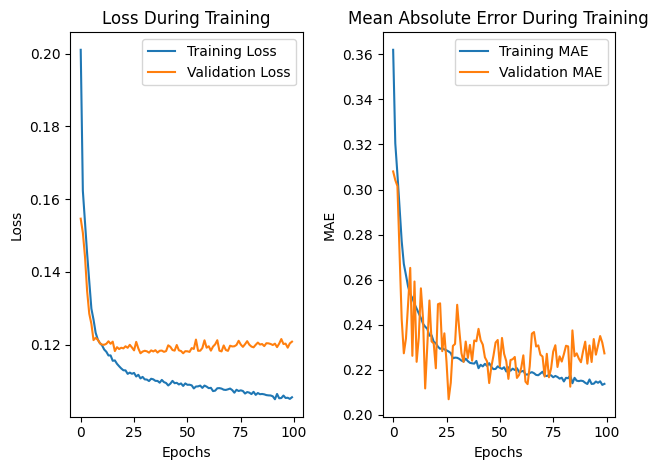

In [9]:
# Plot
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['mae'], label='Training MAE')
plt.plot(lstm_history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
class NutritionRecommender:
    def __init__(self, nutrition_data):
        self.nutrition_data = nutrition_data

    def recommend_nutrition(self, age, stunting_status, weight):
        filtered_data = self.nutrition_data[
            (self.nutrition_data['usia minimal(bulan)'] <= age) &
            (self.nutrition_data['usia maksimal(bulan)'] >= age)
        ]

        if stunting_status == 'Stunting':
            recommended = filtered_data[
                (filtered_data['protein (g)'] > filtered_data['protein (g)'].median()) &
                (filtered_data['kalori'] > filtered_data['kalori'].median())
            ]
        else:
            recommended = filtered_data

        recommended['adjusted_portion'] = recommended['kalori'] * (weight / 10)

        return recommended.sort_values('adjusted_portion', ascending=False).head(5)

recommender = NutritionRecommender(nutrition_data)
recommendations = recommender.recommend_nutrition(age=24, stunting_status='Stunting', weight=10)


<ipython-input-10-c6628a803681>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended['adjusted_portion'] = recommended['kalori'] * (weight / 10)


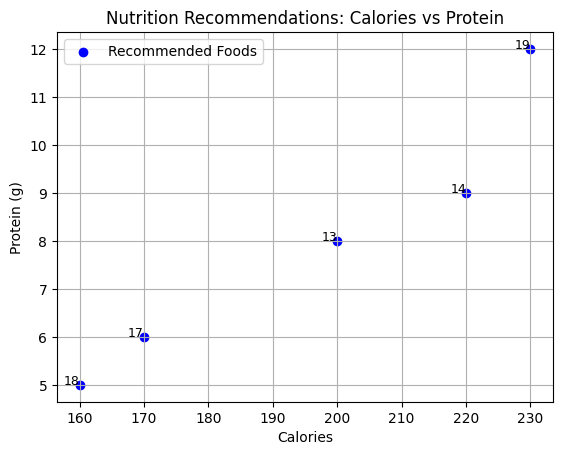

In [11]:
plt.scatter(recommendations['kalori'], recommendations['protein (g)'], color='blue', label='Recommended Foods')
plt.title('Nutrition Recommendations: Calories vs Protein')
plt.xlabel('Calories')
plt.ylabel('Protein (g)')
plt.grid(True)

for i in range(len(recommendations)):
    plt.text(recommendations['kalori'].iloc[i], recommendations['protein (g)'].iloc[i],
             f"{recommendations.index[i]}", fontsize=9, ha='right')

plt.legend()
plt.show()

In [17]:
class NutritionRecommender:
    def __init__(self, nutrition_data):
        self.nutrition_data = nutrition_data

    def recommend_nutrition(self, age, stunting_status, weight):
        filtered_data = self.nutrition_data[
            (self.nutrition_data['usia minimal(bulan)'] <= age) &
            (self.nutrition_data['usia maksimal(bulan)'] >= age)
        ]

        if stunting_status == 'Stunting':
            recommended = filtered_data[
                (filtered_data['protein (g)'] > filtered_data['protein (g)'].median()) &
                (filtered_data['kalori'] > filtered_data['kalori'].median())
            ]
        else:
            recommended = filtered_data

        recommended['adjusted_portion'] = recommended['kalori'] * (weight / 10)

        top_recommendations = recommended.sort_values('adjusted_portion', ascending=False).head(5)

        recommendations_text = "Berikut adalah rekomendasi kebutuhan gizi berdasarkan umur dan berat badan Anda:\n"
        recommendations_text += "-" * 80 + "\n"

        for index, row in top_recommendations.iterrows():
            recommendations_text += (
                f"Rekomendasi :"
                f"Untuk anak dengan usia {row['usia minimal(bulan)']} - {row['usia maksimal(bulan)']} bulan,\n"
                f"Disarankan makanan dengan {row['protein (g)']} gram protein dan {row['kalori']} kalori per porsi.\n"
                f"Karena berat badan anak anda {weight} kg, maka porsi makanan yang disesuaikan adalah {row['adjusted_portion']} kalori.\n\n"
            )

        return recommendations_text

age = int(input("Masukkan usia anak (dalam bulan): "))
stunting_status = input("Masukkan status stunting (Stunting / Tidak Stunting): ")
weight = float(input("Masukkan berat badan anak (dalam kg): "))

recommender = NutritionRecommender(nutrition_data)
recommendations_text = recommender.recommend_nutrition(age=age, stunting_status=stunting_status, weight=weight)

print(recommendations_text)


Masukkan usia anak (dalam bulan): 59
Masukkan status stunting (Stunting / Tidak Stunting): Stunting
Masukkan berat badan anak (dalam kg): 9
Berikut adalah rekomendasi kebutuhan gizi berdasarkan umur dan berat badan Anda:
--------------------------------------------------------------------------------
Rekomendasi :Untuk anak dengan usia 18 - 60 bulan,
Disarankan makanan dengan 12.0 gram protein dan 230 kalori per porsi.
Karena berat badan anak anda 9.0 kg, maka porsi makanan yang disesuaikan adalah 207.0 kalori.

Rekomendasi :Untuk anak dengan usia 18 - 60 bulan,
Disarankan makanan dengan 9.0 gram protein dan 220 kalori per porsi.
Karena berat badan anak anda 9.0 kg, maka porsi makanan yang disesuaikan adalah 198.0 kalori.

Rekomendasi :Untuk anak dengan usia 18 - 60 bulan,
Disarankan makanan dengan 8.0 gram protein dan 200 kalori per porsi.
Karena berat badan anak anda 9.0 kg, maka porsi makanan yang disesuaikan adalah 180.0 kalori.

Rekomendasi :Untuk anak dengan usia 18 - 60 bulan,
D

<ipython-input-17-1fcbf546b6d3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended['adjusted_portion'] = recommended['kalori'] * (weight / 10)
